In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from varname import nameof

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Create dataset for regression analysis

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df = df[df.index.duplicated()==False]  

In [5]:
solar = pd.read_csv(os.path.join(data_path, "solar.csv"), index_col=0)
solar.index = pd.DatetimeIndex(solar.index)
solar = solar.resample("D").mean()
solar.loc[(solar.index >= df.index[0]) & (solar.index <= df.index[-1])]
solar[solar.index.duplicated()==False]

solar = solar * 2.77778e-7
solar = solar.rename(columns={"solar [J/m^2]" : "solar [kWh/m^2]"})

In [6]:
temperature = pd.read_csv(os.path.join(data_path, "aggregated_temperature.csv"), index_col=0)
temperature.index = pd.DatetimeIndex(temperature.index)
temperature = temperature.resample("D").mean()
temperature = temperature.loc[df.index[0]:df.index[-1]]
temperature[temperature.index.duplicated()==False]

ref_temperature = pd.read_csv(os.path.join(data_path, "aggregated_reference_temperature.csv"), index_col=0)
ref_temperature.index = pd.DatetimeIndex(ref_temperature.index)
ref_temperature = ref_temperature.resample("D").mean()
ref_temperature = ref_temperature.loc[df.index[0]:df.index[-1]]

In [7]:
producing_sector = pd.read_csv(os.path.join(data_path, "manufacturing.csv"), index_col=0, sep=";", dtype={"Kalender- und saisonbereinigt nach X13 JDemetra+":np.float64}, decimal=",")
producing_sector = producing_sector.iloc[:,1] #0: original, 1: cleaned values
producing_sector.index = pd.DatetimeIndex(producing_sector.index)
producing_sector.resample("D").sum()
producing_sector = producing_sector.reindex(df.index, method = "nearest")
producing_sector = producing_sector.loc[df.index[0]:df.index[-1]]
producing_sector.index = df.index 

df["producing_sector"] = producing_sector

In [8]:
automotive = pd.read_excel(os.path.join(data_path, "Produktion_Branchen_Produzierendes_Gewerbe.xlsx"), sheet_name = "Daten", index_col=0)
automotive = automotive.iloc[:,1]
automotive.index = pd.DatetimeIndex(automotive.index)
automotive.resample("D").sum()
automotive = automotive.reindex(df.index, method = "nearest")
automotive = automotive.loc[df.index[0]:df.index[-1]]
automotive.index = df.index 

df["automotive"] = automotive

In [9]:
final_values_date = pd.Timestamp("30-04-2022")
df = df.loc[:final_values_date]

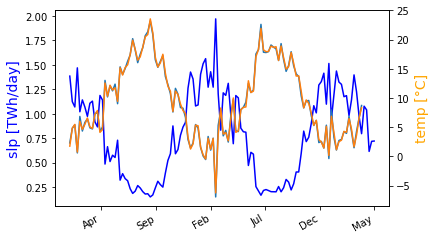

In [10]:
fig,ax = plt.subplots()

ax.plot(df["scaled_space_private"].resample("w").mean(), color="blue")
ax.set_ylabel("slp [TWh/day]",  color="blue", fontsize=14)

ax2=ax.twinx()
ax2.plot(pd.concat([temperature, ref_temperature], axis=1).resample("w").mean())
ax2.set_ylabel("temp [°C]", color="orange", fontsize=14)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.show()

temperature.index = df.index
ref_temperature.index = df.index

df["temperature"] = temperature
df["ref_temperature"] = ref_temperature

# Disaggregation based on fundamental assumption / energy balances

plt.figure(figsize=(10,5))

entso_g = df['bdew [TWh]']
entso_g.plot(label='ENTSO-G')

slp_res = entso_g - df['aggregated(incl_small_chp)']
plt.plot(df.index, slp_res, color='tab:red', label=' minus SLP', linewidth=0.5)
plt.fill_between(df.index, entso_g, slp_res, color='tab:red', alpha=0.1)

power_res = slp_res - df['gas_to_electricity']
plt.plot(df.index, power_res, color='tab:grey', label=' minus power sector', linewidth=0.5)
plt.fill_between(df.index, slp_res, power_res, color='tab:grey', alpha=0.1)

#plt.fill_between(df.index, power_res, 0, color='tab:blue', alpha=0.1)


plt.xlim('2021-01-01', '2022-03-25')
plt.ylim(0, 6.5)
plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right')
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))


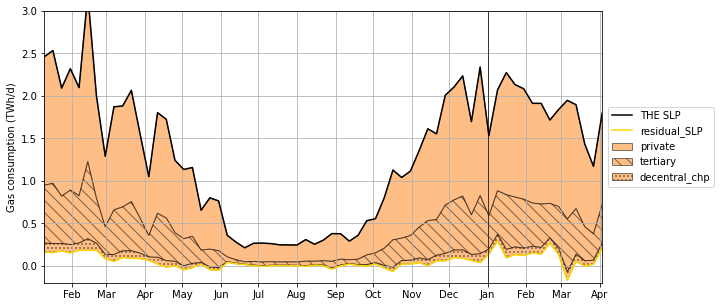

In [11]:
#weekly
plt.figure(figsize=(10,5))
dft = df.resample("1w").mean().dropna()
plt.xlim(dft.index[[0, -1]])

#scaling factors from AGEBL
private = dft["scaled_space_private"] 
tertiary = dft["scaled_space_tertiary"]
decentral_chp = dft["scaled_decentral_chp"]

upper=dft['the_combined_slp']
plt.plot(dft.index, dft['the_combined_slp'], label='THE SLP', color="k")
for sector,h,label in [(private, " ", "private"), (tertiary,  "\\\\", "tertiary"), (decentral_chp, "...", "decentral_chp")]:
    plt.fill_between(dft.index, upper-sector, upper, color="tab:orange", hatch=h, edgecolor="k", alpha=0.5, label=label)
    upper = upper - sector 

plt.plot(upper.index, upper, color="gold", label="residual_SLP")



plt.ylim(-0.2, 3)
plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

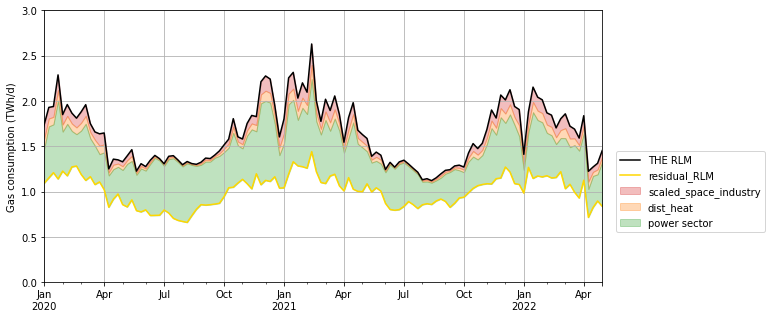

In [12]:
plt.figure(figsize=(10,5))

dft= df.resample("1w").mean()
the_rlm = dft['the_combined_rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - dft['gas_to_electricity']
industry = dft["scaled_space_industry"]

upper=the_rlm
for sector, c, label in [(industry,"tab:red","scaled_space_industry"), (dft["scaled_district_heat"], "tab:orange", "dist_heat"), (dft['gas_to_electricity'],  "tab:green", "power sector")]:
    plt.fill_between(dft.index, upper-sector, upper , color="{}".format(c), alpha=0.3, label=label)
    upper = upper-sector 
upper.plot(color="gold", label="residual_RLM")

plt.xlim(power_res.dropna().index[[0, -1]])
plt.ylim(0, 3)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

plt.show()

# Estimations: X^= a + b*X

In [13]:
df_x = df
#df_x["power"]=df["electricity_from_gas"]**2
#df_x["power"]=df["electricity_from_gas"]**2
df_x["solar"] = solar
#df_x["temperature"] = temperature
df_x = df_x.rename(columns = {
    "aggregated(incl_small_chp)" : "slp_w2h",
    "dist_heat": "slp_w2h_dh",
    "the_combined_slp" : "slp_the",
    "the_combined_rlm" : "rlm_the",
    "bdew [TWh]" : "bdew",
    "gas_price [$/lhs]" : "prices"
})

In [14]:
df_x["the_sum"] = df_x["rlm_the"] + df_x["slp_the"]

In [15]:
df_x_no_holiday = df_x[(df_x.holiday==0) & (df_x.christmas_period==0) & (df_x.bridgeday==0)]

## Fit model to 2021 and predict for 2022

In [16]:
df_x_no_holiday_2022 = df_x_no_holiday.loc[df_x_no_holiday.index.year == 2022]

In [17]:
df_x_no_holiday_2021 = df_x_no_holiday.loc[df_x_no_holiday.index.year == 2021]

In [18]:
#df_x_no_holiday = df_x_no_holiday.drop(columns="index")

In [19]:
df_x_no_holiday.columns

Index(['slp_the', 'rlm_the', 'bdew', 'gas_to_electricity',
       'electricity_from_gas', 'gas_price [€/MWh]', 'scaled_space_private',
       'scaled_space_tertiary', 'scaled_decentral_chp',
       'scaled_space_industry', 'scaled_district_heat', 'slp_w2h', 'index',
       'time', 'year', 'month', 'weekday', 'weekday_num', 'monday', 'friday',
       'weekend', 'christmas_period', 'holiday', 'bridgeday',
       'producing_sector', 'automotive', 'solar', 'the_sum'],
      dtype='object')

## THE_RLM

In [20]:
high_gas_date = "2021-09-01"
covid_beginning = "2020-02-01"
invasion_date = "2022-02-24"

In [21]:
#2020/09-2021/08 (before high gas prices)
model_the_20_09 = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_20_09 = model_the_20_09.fit() 

model_the_16_10 = smf.ols('rlm_the ~ 1 + slp_the + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_16_10 = model_the_16_10.fit() 

result_list = [
    (results_the_20_09,"fitting period: 2020/09 - 2021/08", '2020-09-01', high_gas_date),
    (results_the_16_10,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)
]

In [22]:
#results_the_20_09.summary()
#results_the_16_10.summary()

In [35]:
#2020/09-2021/08 (before high gas prices)
model_the_all = smf.ols('rlm_the ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_all = model_the_all.fit() 

model_the_no_econ = smf.ols('rlm_the ~ 1 + slp_the + electricity_from_gas + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_no_econ = model_the_no_econ.fit() 

model_the_only_slp = smf.ols('rlm_the ~ 1 + slp_w2h + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_only_slp = model_the_only_slp.fit() 

result_list_2016 = [
    (results_the_only_slp, "only_slp"),
    (results_the_no_econ, "no_econ"),
    (results_the_all,"all")
]

In [118]:
results_the_all.summary()
results_the_no_econ.summary()
results_the_only_slp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rlm_the   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2087.
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:16:42   Log-Likelihood:                 745.37
No. Observations:                 561   AIC:                            -1471.
Df Residuals:                     551   BIC:                            -1427.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2256      0.047      4.815      0.000       0.134       0.318
C(weekday)[T.Monday]        0.0629      0.010      6.206      0.000       0.043       0.083
C(weekday)[T.Saturday]     -0.1599      0.010    -15.273      0.000      -0.180      -0.139
C(weekday)[T.Sunday]       -0.1317      0.011    -12.228      0.000      -0.153      -0.111
C(weekday)[T.Thursday]      0.0647      0.010      6.237      0.000       0.044       0.085
C(weekday)[T.Tuesday]       0.0599      0.010      5.842      0.000       0.040       0.080
C(weekday)[T.Wednesday]     0.0644      0.010      6.331      0.000       0.044       0.084
slp_w2h                     0.3453      0.004     92.455      0.000       0.338       0.353
electricity_from_gas        1.6173      0.057     28.563      0.000       1.506       1.729
producing_sector            0.0079      0.001     15.610      0.000       0.007       0.009
==============================================================================
Omnibus:                       21.356   Durbin-Watson:                   0.593
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.428
Skew:                           0.029   Prob(JB):                     2.50e-12
Kurtosis:                       4.511   Cond. No.                     1.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
combined_all = df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["rlm_the"]
key_list = ["reported"]
delta = pd.DataFrame()

result_dict = {
    "all": {},
    "no_econ": {},
    "only_slp": {},
}

energy_amounts = {
    "phase0" : df_x_no_holiday.loc[df_x_no_holiday.index<=high_gas_date]["rlm_the"],
    "phase1" : df_x_no_holiday.loc[
        (df_x_no_holiday.index>high_gas_date) &
        (df_x_no_holiday.index<=invasion_date)
                                  ]["rlm_the"],
    "phase2" : df_x_no_holiday.loc[df_x_no_holiday.index>invasion_date]["rlm_the"]
}

start_fit = '2016-10-01'
end_fit = high_gas_date

for df, name in result_list_2016:
    
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_fit])
    
    df_pred.name = f"{name}_forecast"
    
    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_fit]["rlm_the"]
    ], axis=1, keys=[name, "reported"])
    
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    delta = pd.concat([delta, ts], axis=1)
    
    result_dict[name]["phase0"] = delta[name][delta[name].index <= high_gas_date].sum() / energy_amounts["phase0"].sum()
    result_dict[name]["phase1"] = delta[name][
        (delta[name].index > high_gas_date) & 
        (delta[name].index <=invasion_date)
    ].sum() / energy_amounts["phase1"].sum()
    result_dict[name]["phase2"] = delta[name][delta[name].index > invasion_date].sum() / energy_amounts["phase2"].sum()

Text(0, 0.5, 'regression delta [%]')

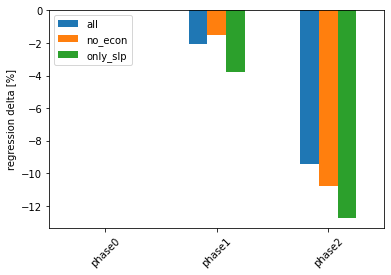

In [26]:
ax = (pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100).plot(kind = "bar", rot=45)
ax.set_ylabel("regression delta [%]")

fitting period: 2020/09 - 2021/08    1.666061
reported                             1.666061
dtype: float64
fitting period: 2016/10 - 2021/08    1.618154
reported                             1.611045
dtype: float64


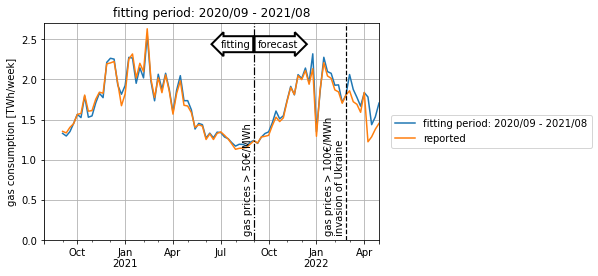

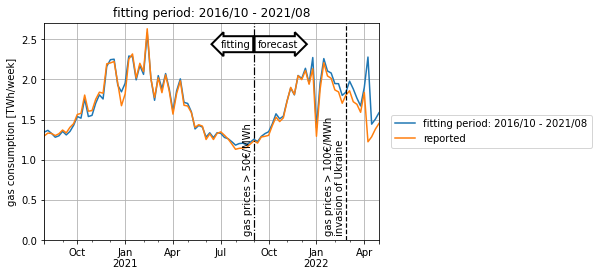

In [41]:
combined_all = df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["rlm_the"]
key_list = ["reported"]
delta_rlm = pd.DataFrame()


for df, name, start_fit, end_fit in result_list:
    
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_fit])
    
    df_pred.name = f"{name}_forecast"

    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_fit]["rlm_the"]
    ], axis=1, keys=[name, "reported"])
    print(combined.loc[(combined.index <=end_fit) & (combined.index >=start_fit)].mean())
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    b = pd.concat([delta_rlm, ts], axis=1)

    ax =combined.loc["2020-04-01":].resample("1w").mean().plot(ylim=0, xlim=("2020-08-01",final_values_date), title = name)
    ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
    ax.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )
    
    ax.text((pd.to_datetime(high_gas_date)-pd.Timedelta(17, "days")).strftime('%Y-%m-%d'), 0.08, "gas prices > 50€/MWh", size=10, rotation=90)
    ax.text((pd.to_datetime(invasion_date)-pd.Timedelta(39, "days")).strftime('%Y-%m-%d'), 0.08, "gas prices > 100€/MWh" + "\n" + "invasion of Ukraine", size=10, rotation=90)

    

    plt.grid()
    ax.set_ylabel("gas consumption [TWh/week]")
    ax.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
    
    key_list.append(name)
    
    combined_all = pd.concat([
        combined_all, df_pred
    ], axis=1, names=key_list)
    
    fit = ax.text(
        (pd.to_datetime(high_gas_date)-pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 2.5, "fitting", ha="right", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
    forecast = ax.text(
        (pd.to_datetime(high_gas_date)+pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 2.5, "forecast", ha="left", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))

In [47]:
delta_rlm.index = combined_all.index
delta_rlm = delta_rlm.dropna()

In [48]:
delta_rlm["2022-02-24":].sum(0)

fitting period: 2020/09 - 2021/08   -7.900099
fitting period: 2016/10 - 2021/08   -9.621061
dtype: float64

since war [TWh]:
fitting period: 2020/09 - 2021/08   -7.900099
fitting period: 2016/10 - 2021/08   -9.621061
dtype: float64
since war [%]:
fitting period: 2020/09 - 2021/08   -7.632060
fitting period: 2016/10 - 2021/08   -9.294631
dtype: float64weekly [TWh]:
fitting period: 2020/09 - 2021/08   -0.987512
fitting period: 2016/10 - 2021/08   -1.202633
dtype: float64


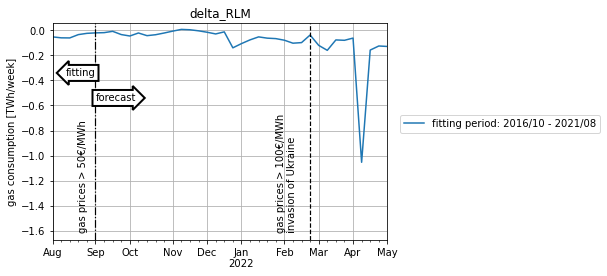

In [115]:
Q1_rlm = delta_rlm["2022-02-24":].sum(0)
percent = Q1_rlm / combined["fitting period: 2016/10 - 2021/08"]["2022-02-24":].sum(0)*100
weekly_rlm = Q1_rlm / len(delta_rlm["2022-02-24":].index) * 7
print("since war [TWh]:"+ "\n"+ str(Q1_rlm) + "\n" + "since war [%]:" + "\n"+ str(percent) + 
      "weekly [TWh]:" + "\n"+ str(weekly_rlm))

resampled = delta_rlm.resample("1w").mean().iloc[:, 1]

resampled.loc[resampled.index>="2021-08-01"].plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="delta_RLM").set_ylabel("gas consumption [TWh/week]")
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))

plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
plt.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )

plt.text((pd.to_datetime(high_gas_date)-pd.Timedelta(10, "days")).strftime('%Y-%m-%d'), -1.6, "gas prices > 50€/MWh", size=10, rotation=90)
plt.text((pd.to_datetime(invasion_date)-pd.Timedelta(25, "days")).strftime('%Y-%m-%d'), -1.6, "gas prices > 100€/MWh" + "\n" + "invasion of Ukraine", size=10, rotation=90)

plt.ylabel("gas consumption [TWh/week]")
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))

key_list.append(name)

combined_all = pd.concat([
    combined_all, df_pred
], axis=1, names=key_list)

fit = plt.text(
    (pd.to_datetime(high_gas_date)-pd.Timedelta(2, "days")).strftime('%Y-%m-%d'), -0.3, "fitting", ha="right", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
forecast = plt.text(
    (pd.to_datetime(high_gas_date)+pd.Timedelta(4, "days")).strftime('%Y-%m-%d'), -0.5, "forecast", ha="left", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))

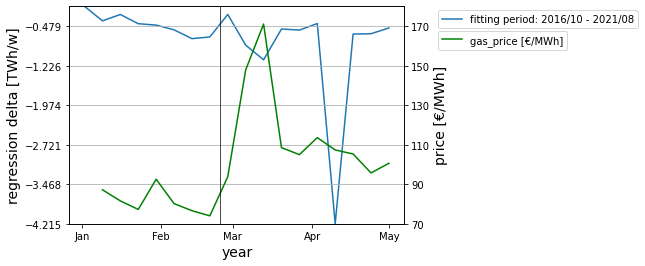

In [117]:
fig,ax = plt.subplots()

column = delta_rlm.columns[1] 
data = delta_rlm.loc[delta_rlm.index.year==2022, column].resample("w").sum()

ax.plot(data, label=column)

ax.set_ylim(data.min(), data.max())
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)

step_size = 20 / 110*(data.max() - data.min()) 
ax.set_yticks(np.arange(data.min(), data.max(), step_size))

ax.legend(loc=(1.1,0.9))

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["gas_price [€/MWh]"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="green", label="gas_price [€/MWh]")

ax2.set_ylabel("price [€/MWh]", fontsize=14)
ax2.set_ylim(70, 180)
ax2.set_yticks(np.arange(70, 180, 20))

ax2.legend(loc=(1.1,0.8))

plt.axvline(x=invasion_date, color='k', lw=0.7)
#plt.axhline(y=0, color='k', lw=1.2)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

## SLP

In [ ]:
#SLP
model_the_slp = smf.ols('slp_the ~ 1 + slp_w2h + C(weekday)', 
                            data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_slp = model_the_slp.fit() 
results_the_slp.summary()

In [ ]:
#SLP
model_the_slp_long = smf.ols('slp_the ~ 1 + slp_w2h + C(weekday)', 
                            data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_slp_long = model_the_slp.fit() 
results_the_slp.summary()

## Vizualize and analyze predictions

In [ ]:
the_slp_prediction = results_the_slp.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction.name = "the_slp_forecast"

the_slp_combined = pd.concat([
    the_slp_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp_the"]
], axis=1, keys=["predicted", "reported"])

the_slp_combined.resample("1w").mean().plot(ylim=0,  title="fitting period: 2020/09 - 2021/08").set_ylabel("gas consumption [TWh/day]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 

the_slp_prediction_long = results_the_slp_long.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction_long.name = "the_slp_forecast"

the_slp_combined_long = pd.concat([
    the_slp_prediction_long, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp_the"]
], axis=1, keys=["predicted", "reported"])

the_slp_combined_long.resample("1w").mean().plot(ylim=0,  title="fitting period: 2016/10 - 2021/08").set_ylabel("gas consumption [TWh/day]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 

plt.show()



plt.show()


In [ ]:
delta_the_slp = the_slp_combined.iloc[:,1]-the_slp_combined.iloc[:,0]
delta_the_slp_long = the_slp_combined_long.iloc[:,1]-the_slp_combined_long.iloc[:,0]

In [ ]:
delta_the_slp.plot()

In [ ]:
delta_the_slp_long.plot()